# Import Packages

In [1]:
# Method #1 GARCH Model
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Method #2 HAR-X Model
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Method #3 Regularisation Model
from sklearn.linear_model import ElasticNet

# Method #4 LSTM Model

# Method #5 TFT Model

from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import warnings

# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

# Data Processing

In [73]:
base_FTSE_df = pd.read_csv('../Data/1.3-FTSE_Monthly_ESG_Volatility_Final.csv')
base_FTSE_df = base_FTSE_df.rename(columns={'Date_x':'date_key'})

base_FTSE_df.Date = pd.to_datetime(base_FTSE_df.date_key)
base_FTSE_df.Asset = base_FTSE_df.Asset.astype(int)
base_FTSE_df.index = base_FTSE_df.date_key

## Fillna

In [74]:
asset = 8589934333

base_SAMPLE_df = base_FTSE_df[base_FTSE_df.Asset == asset]
base_SAMPLE_df.index = base_SAMPLE_df.date_key

vol_series = base_SAMPLE_df['V^YZ']
vol_series_daily = vol_series.shift(1)
vol_series_weekly = vol_series.rolling(5).mean().shift(1)
vol_series_monthly = vol_series.rolling(22).mean().shift(1)

m1_df = pd.DataFrame({
    'vol': vol_series,
    'vol_lag_daily': vol_series_daily,
    'vol_lag_weekly': vol_series_weekly,
    'vol_lag_monthly': vol_series_monthly
    }
).dropna()

test_size = int(0.2*m1_df.shape[0])
m1_train_df = m1_df.iloc[:-test_size, ]
m1_test_df = m1_df.iloc[-test_size:, ]

y_train = m1_train_df['vol']
X_train = m1_train_df[['vol_lag_daily', 'vol_lag_weekly', 'vol_lag_monthly']]

y_test = m1_test_df['vol']
X_test = m1_test_df[['vol_lag_daily', 'vol_lag_weekly', 'vol_lag_monthly']]

# Modeling

## GARCH

### Training

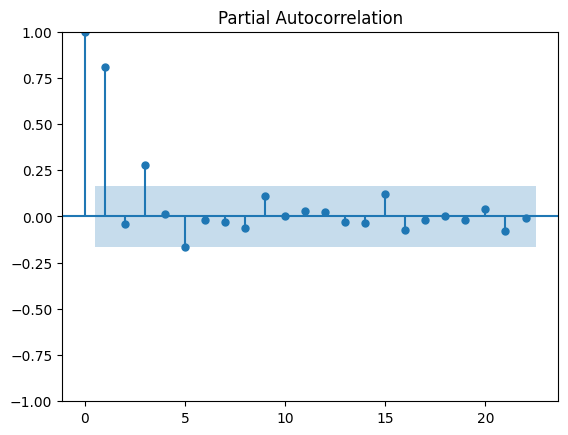

In [75]:
plot_pacf(y_train)
plt.show()

In [76]:
GARCH_model = arch_model(y_train, p=1, q=1)
GARCH_model = GARCH_model.fit(update_freq=10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -404.9086868204807
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


In [77]:
GARCH_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                404.909
Distribution:                  Normal   AIC:                          -801.817
Method:            Maximum Likelihood   BIC:                          -789.910
                                        No. Observations:                  145
Date:                Mon, Jul 10 2023   Df Residuals:                      144
Time:                        21:20:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0213  1.912e-03     11.156  6.686e-29 [1.758e-02,2.508e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.7780e-05  1.182e-04      0.404      0.686 [-1.838e-04,2.794e-04]
alpha[1]       0.2000      0.299      0.669      0.504      [ -0.386,  0.786]
beta[1]        0.7000      0.335      2.089  3.674e-02    [4.313e-02,  1.357]
=============================================================================

Covariance estimator: robust
"""

### Testing

In [78]:
predictions = GARCH_model.forecast(horizon=test_size)

In [79]:
indices = y_test.index
predictions = pd.Series(predictions.variance.values[-1, :], indices)

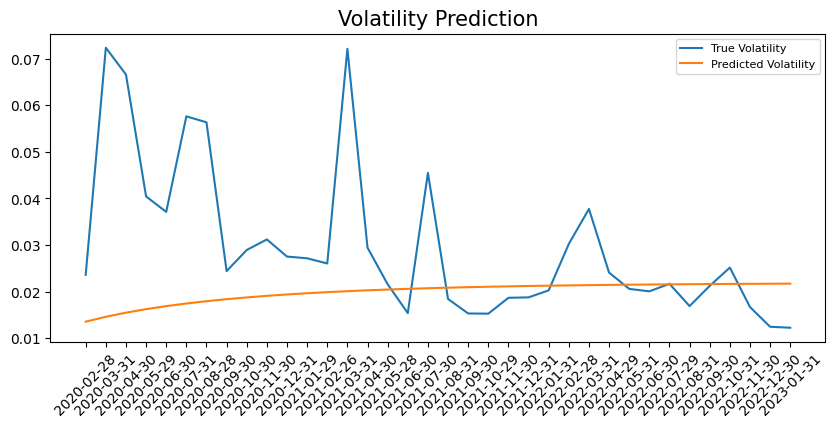

In [80]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(np.sqrt(predictions))
plt.title('Volatility Prediction', fontsize=15)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=8)
plt.xticks(rotation=45)
plt.show()

In [81]:
def GARCH_rolling_pred(y_volatility, test_size, p=1, q=1):
    rolling_predictions = []
    for i in range(test_size):
        try:
            train = y_volatility[:-(test_size-i)]
            model = arch_model(train, p=p, q=q)
            model_fit = model.fit(disp='off', update_freq=10)
            pred = model_fit.forecast(horizon=1)
            rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        except (ValueError, Exception) as e:
            print(f"Error encountered at i={i}: {e}")
            rolling_predictions.append(max(train))

    indices = y_volatility[-test_size:].index
    rolling_predictions = pd.Series(rolling_predictions, index=indices)

    return rolling_predictions

In [82]:
pred_GARCH_rolling = GARCH_rolling_pred(m1_df['vol'], test_size)

In [83]:
# pred_GARCH_rolling = pred_GARCH_rolling.apply(lambda x: max(y_train) if x > max(y_train) else x)

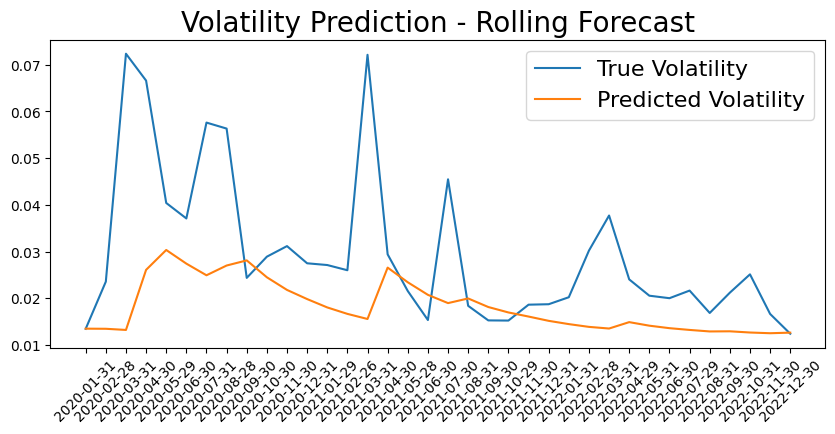

In [69]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(pred_GARCH_rolling)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)
plt.xticks(rotation=45)
plt.show()

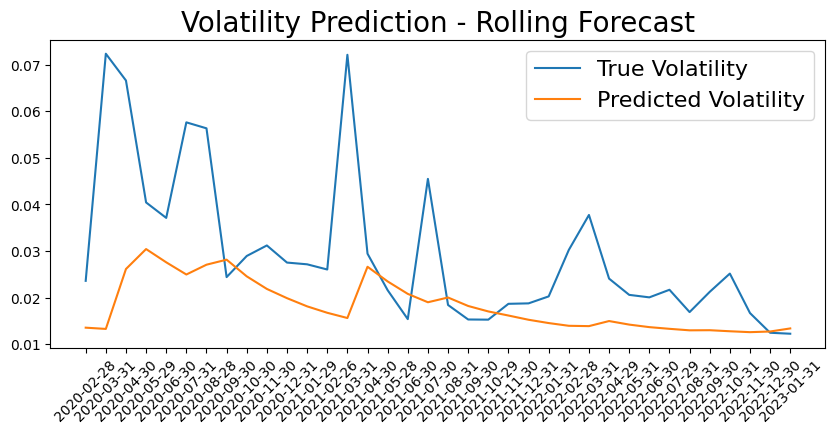

In [84]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(pred_GARCH_rolling)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [85]:
mse_million = mean_squared_error(y_test,pred_GARCH_rolling)*10**6

In [42]:
HAR_result = pd.DataFrame({
    'Model':'GARCH(1,1)',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(HAR_result)

,Model,Test Size,MSE^6
0,"GARCH(1,1)",36,362.885203


In [86]:
HAR_result = pd.DataFrame({
    'Model':'GARCH(1,1)',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(HAR_result)

,Model,Test Size,MSE^6
0,"GARCH(1,1)",36,361.965006


---

## Heterogeneous AutoRegressive (HAR)

In [87]:
# Add a constant to the independent variables matrix
X_train = add_constant(X_train)

# Fit the model
model = OLS(y_train, X_train)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     91.40
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           6.64e-33
Time:                        21:20:56   Log-Likelihood:                 426.94
No. Observations:                 145   AIC:                            -845.9
Df Residuals:                     141   BIC:                            -834.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.003     

In [88]:
y_test = m1_test_df['vol']

# Define the independent variables
X_test = m1_test_df[['vol_lag_daily', 'vol_lag_weekly', 'vol_lag_monthly']]

# Add a constant to the independent variables matrix
X_test = add_constant(X_test)

In [89]:
y_pred = model_fit.predict(X_test)

In [90]:
X_test.head(2)

,const,vol_lag_daily,vol_lag_weekly,vol_lag_monthly
date_key,,,,
2020-02-28,1.0,0.013481,0.019321,0.016663
2020-03-31,1.0,0.023580,0.018932,0.017001


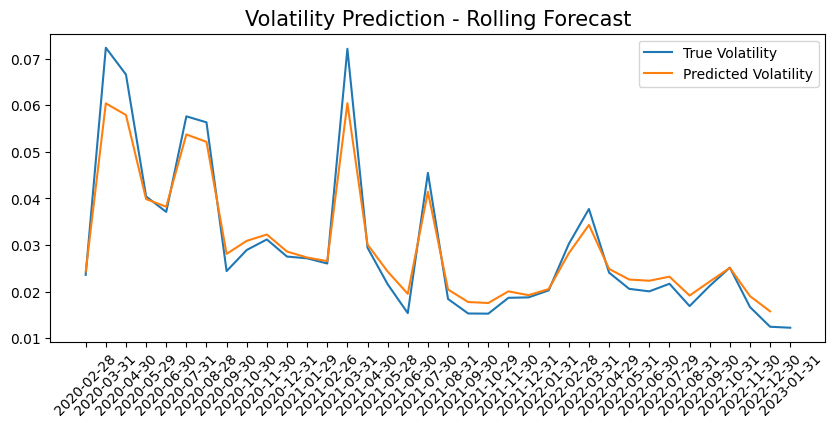

In [93]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(y_pred.shift(-1))
plt.title('Volatility Prediction - Rolling Forecast', fontsize=15)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=10)
plt.xticks(rotation=45)
plt.show()

In [94]:
mse_million = mean_squared_error(y_test,y_pred)*10**6

In [95]:
HAR_result = pd.DataFrame({
    'Model':'Heterogeneous AutoRegressive',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(HAR_result)

,Model,Test Size,MSE^6
0,Heterogeneous AutoRegressive,36,244.900214


## Elastic Net

In [ ]:
asset = 8589934333

base_SAMPLE_df = base_FTSE_df[base_FTSE_df.Asset == asset]
base_SAMPLE_df.index = base_SAMPLE_df.Date

In [99]:
X_train = X_train.drop(['const'], axis=1)

In [102]:
X_test = X_test.drop(['const'], axis=1)

### Training Data

In [100]:
# Train the model
model = ElasticNet(l1_ratio=0.5)  # set l1_ratio to something between 0 and 1. 0.5 gives equal weight to L1 and L2 penalties
model.fit(X_train, y_train)

ElasticNet()

### Predict Data

In [103]:
y_pred = model.predict(X_test)

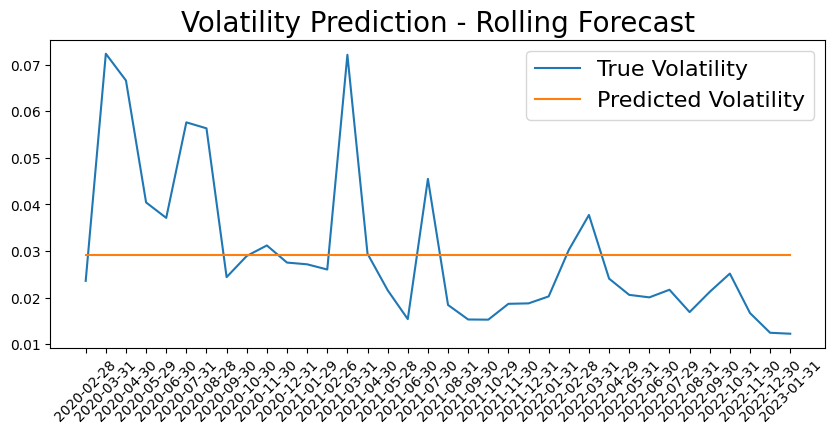

In [105]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(pd.Series(y_pred, index=y_test.index))
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [106]:
mse_million = mean_squared_error(y_test,y_pred)*10**6
ELASTICNet_res = pd.DataFrame({
    'Model':'Elastic Net',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(ELASTICNet_res)

,Model,Test Size,MSE^6
0,Elastic Net,36,264.289541


# LSTM

In [107]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers.regularization.gaussian_noise import GaussianNoise
from keras.optimizers import rmsprop_v2

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python import keras

In [112]:
# lookback window 5 and train 5 batch
lags = 7
batch_size = 15

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

def create_rnn_model(hu=32, lags=lags, layer='SimpleRNN',
                           features=1, output_size = 1, algorithm='estimation'):
    
    model = Sequential()
    if layer == 'SimpleRNN':
        model.add(SimpleRNN(hu, activation='relu',
                            input_shape=(lags, features)))
    else:
        model.add(LSTM(hu, activation='relu',
                       input_shape=(lags, features)))
    if algorithm == 'estimation':
        model.add(Dense(output_size, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:
        model.add(Dense(output_size, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

In [ ]:
lags = 5
batch_size = 5*3

In [113]:
test_size = int(0.2*m1_df.shape[0])
m1_train_df = m1_df.iloc[:-test_size, ]
m1_test_df = m1_df.iloc[-test_size:, ]

y_train = m1_train_df['vol']
X_train = m1_train_df[['vol_lag_daily', 'vol_lag_weekly', 'vol_lag_monthly']]

## Data Standardisation

In [114]:
X_train

,vol_lag_daily,vol_lag_weekly,vol_lag_monthly
Date,,,
2006-02-09,0.012019,0.016454,0.013351
2006-02-10,0.012788,0.015421,0.013436
2006-02-13,0.013104,0.014587,0.013544
2006-02-14,0.012807,0.013666,0.013613
2006-02-15,0.012271,0.012598,0.013626
...,...,...,...
2019-08-08,0.020227,0.021339,0.014363
2019-08-09,0.017995,0.020926,0.014627
2019-08-12,0.019720,0.020707,0.014913


---

In [116]:
'''
if you need a fixed training window, you will control the 
n_windows and max_train_size by yourself
'''
rows, cols = X_train.shape
# length of the training window for approx 12 months = 360 days
train_window = 30*12
# adding gap to test set
n_gap = 3
# length of testing window
test_size = int(train_window*0.1)

# number of windows
# n_windows = int( (rows-train_window-n_gap)/test_size )
# n_windows = int( (rows-train_window)/test_size )
n_windows = rows // (train_window + test_size) * n_gap
# n_windows = 11

print("Training window = ", train_window, "\nTest window =", test_size, 
      '\nn_windows cross validation:', n_windows)

tscv = TimeSeriesSplit( 
    n_splits=n_windows, 
    max_train_size=train_window, 
    test_size=test_size,
    gap=n_gap 
)

Training window =  360 
Test window = 36 
n_windows cross validation: 24


NameError: name 'TimeSeriesSplit' is not defined

# Author Notes

- The GARCH model suffers from the warning that the data might be not stationer (?). Here is the solution from GPT.

The warning you're seeing, specifically the "Inequality constraints incompatible" message, typically arises when the optimization routine used to estimate the GARCH model parameters is having difficulty finding a solution that satisfies all of the constraints imposed on the problem.

The GARCH model imposes several constraints on its parameters, such as requiring that they be non-negative, and that the persistence parameter be less than 1 for the model to be stationary. If the optimizer is struggling to find a set of parameter values that satisfy these constraints and also fit the data well, it may return this warning.

Here are a few potential solutions to try:

1. **Start Values:** You can try changing the starting values used by the optimizer, which might help it find a valid solution. You can do this by setting the `starting_values` argument in the `fit()` method.

2. **Differencing or Transforming the Data:** If your data are not stationary, or exhibit non-constant variance, this could cause problems for the GARCH model. You might need to preprocess your data by differencing or applying some transformation (e.g., logarithm) to stabilize the variance.

3. **Trying a Different Model Specification:** It might be that a GARCH(1, 1) model is not a good fit for your data. You could try a different model specification, such as changing the orders of the GARCH model, or using an EGARCH or GJR-GARCH model, which allow for asymmetric responses to positive and negative shocks.

4. **Increase the Maximum Iteration:** The solver might not have enough iterations to reach the optimal solution. By increasing the max number of iterations (`maxiter` in `fit()`), you may allow the solver to reach a suitable solution.

Here's an example of how you might change the starting values:

```python
starting_vals = np.array([.01, .05, .92])  # You might need to change these values
model_fit = model.fit(starting_vals=starting_vals, disp='off')
```

Remember to take the model diagnostics (like the ACF and PACF of the residuals, the p-values of the coefficients, etc.) and the economic and statistical theory into consideration while specifying your model, preprocessing the data, or interpreting the results.